In [1]:
!pip install kaggle

In [2]:
!kaggle competitions download -c telstra-recruiting-network

403 - Forbidden


In [3]:
!unzip telstra-recruiting-network.zip

Archive:  telstra-recruiting-network.zip
  inflating: event_type.csv.zip      
  inflating: log_feature.csv.zip     
  inflating: resource_type.csv.zip   
  inflating: sample_submission.csv.zip  
  inflating: severity_type.csv.zip   
  inflating: test.csv.zip            
  inflating: train.csv.zip           


In [ ]:
#https://www.udemy.com/course/12-real-world-case-studies-for-machine-learning/learn/lecture/17306018#overview
#https://www.kaggle.com/c/telstra-recruiting-network/overview
#https://www.kaggle.com/acauveri/network-severity-prediction-automatic-model
#https://github.com/dwipam/code/blob/master/Telstra/Telstra.ipynb

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import ensemble
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
plt.rc('figure', figsize=(12.0, 6.0))

In [39]:
event_type=pd.read_csv("event_type.csv",error_bad_lines=False)
train = pd.read_csv("train.csv")
severity_type = pd.read_csv("severity_type.csv")
log_feature = pd.read_csv("log_feature.csv")
test = pd.read_csv("test.csv")
resource_type = pd.read_csv("resource_type.csv",error_bad_lines=False)
sample_submission = pd.read_csv("sample_submission.csv")

In [5]:
train.shape, test.shape

((7381, 3), (11171, 2))

In [6]:
print('test',test.head())
print('train',train.head(4))
print('sample_submission',sample_submission.head())
print('event_type',event_type.shape,event_type.head(2))
print('severity_type',severity_type.shape,severity_type.head(2))
print('log_feature',log_feature.shape,log_feature.head(2))
print('resource_type',resource_type.shape,resource_type.head(2))

test       id      location
0  11066  location 481
1  18000  location 962
2  16964  location 491
3   4795  location 532
4   3392  location 600
train       id      location  fault_severity
0  14121  location 118               1
1   9320   location 91               0
2  14394  location 152               1
3   8218  location 931               1
sample_submission       id  predict_0  predict_1  predict_2
0  11066          0          1          0
1  18000          0          1          0
2  16964          0          1          0
3   4795          0          1          0
4   3392          0          1          0
event_type (31170, 2)      id     event_type
0  6597  event_type 11
1  8011  event_type 15
severity_type (18552, 2)      id    severity_type
0  6597  severity_type 2
1  8011  severity_type 2
log_feature (58671, 3)      id log_feature  volume
0  6597  feature 68       6
1  8011  feature 68       7
resource_type (21076, 2)      id    resource_type
0  6597  resource_type 8
1  8011  reso

In [7]:
round(train['fault_severity'].value_counts() / len(train)*100,2)

0    64.82
1    25.35
2     9.84
Name: fault_severity, dtype: float64

In [40]:
# train_merge1=merge_fn(train,event_type.drop_duplicates(subset=['id']),'id','left')
# train_merge2=merge_fn(train_merge1,severity_type.drop_duplicates(subset=['id']),'id','left')
# train_merge3=merge_fn(train_merge2,log_feature.drop_duplicates(subset=['id']),'id','left')
# train_merge4=merge_fn(train_merge3,resource_type.drop_duplicates(subset=['id']),'id','left')
from functools import reduce
def merge_data_frames(data_frames):
    df = reduce(lambda left, right: pd.merge(left, right.drop_duplicates(subset=['id']), on='id', how='left'), data_frames)
    return df
data_frames = [train, event_type, severity_type, log_feature, resource_type]
train = merge_data_frames(data_frames)
data_frames[0] = test
test = merge_data_frames(data_frames)

In [9]:
train.shape, test.shape

((7381, 8), (11171, 7))

In [10]:
train.head()

,id,location,fault_severity,event_type,severity_type,log_feature,volume,resource_type
0,14121,location 118,1,event_type 34,severity_type 2,feature 312,19,resource_type 2
1,9320,location 91,0,event_type 34,severity_type 2,feature 315,200,resource_type 2
2,14394,location 152,1,event_type 35,severity_type 2,feature 221,1,resource_type 2
3,8218,location 931,1,event_type 15,severity_type 1,feature 80,9,resource_type 8
4,14804,location 120,0,event_type 34,severity_type 1,feature 134,1,resource_type 2


In [11]:
for column in train.drop('id',axis=1).columns:
    print(f'{column} unique values:{train[column].nunique()}\n')

location unique values:929

fault_severity unique values:3

event_type unique values:45

severity_type unique values:5

log_feature unique values:223

volume unique values:153

resource_type unique values:10



<AxesSubplot:xlabel='severity_type', ylabel='id'>

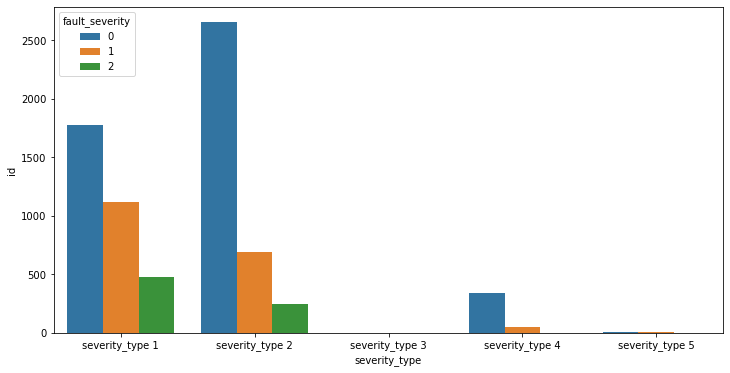

In [12]:
df_grouped = train.groupby(['severity_type','fault_severity']).count().reset_index()
sns.barplot(data=df_grouped, x='severity_type', y='id', hue='fault_severity')

<AxesSubplot:>

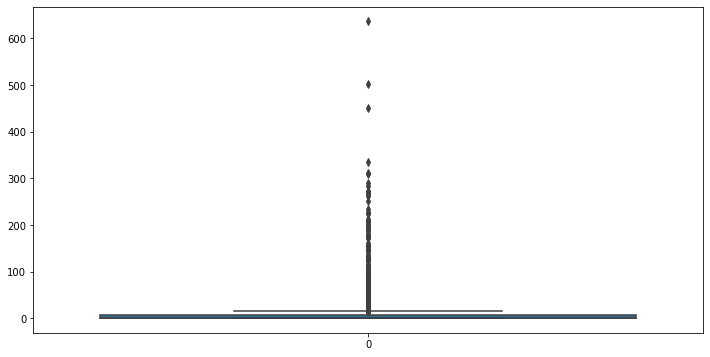

In [13]:
sns.boxplot(data=train['volume'])

In [41]:
#train[train['location']=='location 1107']['fault_severity'].value_counts().sort_index().values / len(train[train['location']=='location 1107']['fault_severity'])

for location in train['location'].unique():
    s = train[train['location']==location]['fault_severity'].value_counts().sort_index()
    if s.get(1):
        train.loc[train['location']==location, 'has_severity_1'] = 1
    else:
        train.loc[train['location']==location, 'has_severity_1'] = 0
    if s.get(2):
        train.loc[train['location']==location, 'has_severity_2'] = 1
    else:
        train.loc[train['location']==location, 'has_severity_2'] = 0

In [42]:
for location in test['location'].unique():
    has_sev_1 = train[train['location']==location]['has_severity_1'].values
    has_sev_2 = train[train['location']==location]['has_severity_2'].values
    if has_sev_1.any():
        test.loc[test['location']==location, 'has_severity_1'] = train[train['location']==location]['has_severity_1'].values[0]
    else:
        test.loc[test['location']==location, 'has_severity_1'] = 0
    if has_sev_2.any():
        test.loc[test['location']==location, 'has_severity_2'] = train[train['location']==location]['has_severity_2'].values[0]
    else:
        test.loc[test['location']==location, 'has_severity_2'] = 0
        

In [43]:
def get_location_mean(train, location):
    return train[train['location']==location]['fault_severity'].mean()

In [44]:
#train.groupby('location').mean()['fault_severity']

In [18]:
def prob_severity_by_location(location):
    train[train['location']==location].value_counts()

In [45]:
train['location_fault_mean'] = train['location'].apply(lambda x: get_location_mean(train, x))

In [51]:
def add_location_fault_mean_to_test(train_df, location):
    mean = 0
    count = 0
    try:
        mean = train_df[train_df['location'] == location]['location_fault_mean'].values[0]
    except Exception as e:
        count +=1
    finally:
        return mean

In [52]:
test['location_fault_mean'] = test['location'].apply(lambda x: add_location_fault_mean_to_test(train, x))

In [58]:
set(train.columns) - set(test.columns)

{'fault_severity'}

### Feature engineering

In [59]:
test['fault_severity'] = -1
all_data = train.append(test)

In [60]:
all_data['mean_volumn']=all_data.groupby(['location','event_type','severity_type','log_feature','resource_type','location_fault_mean', 'has_severity_1', 'has_severity_2'])['volume'].transform('mean')

In [62]:
cols = all_data.select_dtypes('object').columns

In [63]:
def categorical_conversion(df,cat_col):
    for i in range(len(cat_col)):
        df[cat_col[i]]=df[cat_col[i]].astype('category')
    return df

In [64]:
all_data = categorical_conversion(all_data, cols)

In [65]:
all_data.dtypes

id                        int64
location               category
fault_severity            int64
event_type             category
severity_type          category
log_feature            category
volume                    int64
resource_type          category
has_severity_1          float64
has_severity_2          float64
location_fault_mean     float64
mean_volumn             float64
dtype: object

In [66]:
def label_encoding_conversion(df,cat_col):
    le=preprocessing.LabelEncoder()
    for i in range(len(cat_col)):
        df[cat_col[i]]=le.fit_transform(df[cat_col[i]])
    return df


In [67]:
def one_hot_encode(df, cat_cols):
    for col in cat_cols:
        dummies = pd.get_dummies(df[col], drop_first=True, prefix=col)
        df = pd.concat([df, dummies], axis=1)
        df.drop(col, axis=1, inplace=True)
    return df

In [68]:
def encode_id_from_columns(df, cols):
    for col in cols:
        df[col] = df[col].apply(lambda x: int(x.split(' ')[1]))
    return df.astype('int32')

In [69]:
cols = all_data.select_dtypes('category').columns
cols

Index(['location', 'event_type', 'severity_type', 'log_feature',
       'resource_type'],
      dtype='object')

In [70]:
all_data = encode_id_from_columns(all_data, cols)
all_data.head()

,id,location,fault_severity,event_type,severity_type,log_feature,volume,resource_type,has_severity_1,has_severity_2,location_fault_mean,mean_volumn
0,14121,118,1,34,2,312,19,2,1,0,0,17
1,9320,91,0,34,2,315,200,2,1,0,0,205
2,14394,152,1,35,2,221,1,2,1,0,0,1
3,8218,931,1,15,1,80,9,8,1,1,0,5
4,14804,120,0,34,1,134,1,2,1,0,0,1


In [71]:
one_hot_cols = ['severity_type', 'resource_type', 'event_type', 'log_feature']
all_data = one_hot_encode(all_data,one_hot_cols)

In [72]:
print(all_data.shape, (train.shape[0] + test.shape[0]))
all_data.head()

(18552, 340) 18552


,id,location,fault_severity,volume,has_severity_1,has_severity_2,location_fault_mean,mean_volumn,severity_type_2,severity_type_3,...,log_feature_369,log_feature_370,log_feature_374,log_feature_375,log_feature_376,log_feature_377,log_feature_378,log_feature_380,log_feature_381,log_feature_384
0,14121,118,1,19,1,0,0,17,1,0,...,0,0,0,0,0,0,0,0,0,0
1,9320,91,0,200,1,0,0,205,1,0,...,0,0,0,0,0,0,0,0,0,0
2,14394,152,1,1,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,8218,931,1,9,1,1,0,5,0,0,...,0,0,0,0,0,0,0,0,0,0
4,14804,120,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [73]:
train = all_data[all_data['fault_severity'] >= 0]
test = all_data[all_data['fault_severity'] == -1]
train.shape, test.shape

((7381, 340), (11171, 340))

In [74]:
test.drop('fault_severity', axis=1,inplace=True)

### Testing different models

In [75]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [76]:
X = train.copy()
y = X['fault_severity']
X.drop(['fault_severity', 'id'], axis=1, inplace=True)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [77]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [78]:
rnd_clf = RandomForestClassifier()
da_clf = AdaBoostClassifier()
log_clf = LogisticRegression() 
svm_clf = SVC(probability=True)

In [79]:
voting_clf = VotingClassifier(
estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf), ('ada', da_clf)], voting='soft')
#voting_clf.fit(x_train, y_train)

In [80]:
clfs = [rnd_clf, da_clf, log_clf, svm_clf, voting_clf]
for clf in clfs:
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred)) 

RandomForestClassifier 0.7156398104265402
AdaBoostClassifier 0.6892349356804333
LogisticRegression 0.7136086662153013
SVC 0.7176709546377793
VotingClassifier 0.7271496276235613


In [118]:
dict(zip(rnd_clf.feature_importances_, x_train.columns))

{0.12615782528199498: 'id',
 0.16911350998808278: 'location',
 0.21973863700898102: 'fault_severity',
 0.05307043255702785: 'volume',
 0.03292531096605325: 'location_fault_mean',
 0.0957499612991713: 'has_severity_1',
 0.023104770082245544: 'has_severity_2',
 5.3284815477297126e-05: 'mean_volumn',
 0.010205354867491252: 'severity_type_2',
 0.00041988696719021606: 'severity_type_3',
 0.0007016850973964706: 'severity_type_4',
 0.01440425146744589: 'severity_type_5',
 0.0007835700190901204: 'resource_type_10',
 0.0017070824098888492: 'resource_type_2',
 0.0: 'log_feature_94',
 0.002757128031333259: 'resource_type_4',
 0.0018599354897398084: 'resource_type_5',
 0.012584990581653039: 'resource_type_6',
 0.0009227434699362007: 'resource_type_7',
 0.0012473763644781117: 'resource_type_8',
 0.008897242254227186: 'resource_type_9',
 8.309485894229902e-05: 'event_type_10',
 0.0030519322870347157: 'event_type_11',
 0.002075564367496917: 'event_type_12',
 0.011151293886289682: 'event_type_13',
 0.

### Dimensionality reduction

In [119]:
from sklearn.decomposition import PCA

In [120]:
pca = PCA(n_components=0.9)
x_train_compressed = pca.fit_transform(x_train) #later all train data
x_test_compressed = pca.transform(x_test)
pca.explained_variance_ratio_

array([0.28193999, 0.10950475, 0.07872005, 0.05493997, 0.04618073,
       0.03304066, 0.02757757, 0.02126172, 0.02041787, 0.01752729,
       0.01524834, 0.01280427, 0.01203151, 0.01169067, 0.01049247,
       0.00985348, 0.00876488, 0.00795401, 0.00777893, 0.00773687,
       0.00738739, 0.00720684, 0.00651969, 0.00640248, 0.00638589,
       0.00607236, 0.0057869 , 0.00552316, 0.00518312, 0.00474724,
       0.00460648, 0.00439903, 0.00416068, 0.00406739, 0.00399895,
       0.00394296, 0.00379968, 0.00359511, 0.00342725, 0.00325079,
       0.00319658, 0.0027807 ])

In [121]:
x_train_compressed

array([[-5.23662571e-01, -2.97101904e-01, -7.49868956e-01, ...,
         3.01065328e-02,  2.09116470e-02, -9.62972782e-02],
       [ 1.11429837e+00,  2.17347094e-01,  2.47374134e-01, ...,
         2.72567539e-03,  3.28681861e-03,  4.88953649e-02],
       [-2.45782678e-01,  4.91013461e-01, -1.03082400e+00, ...,
         9.54740905e-03,  2.57337299e-03, -7.37461212e-02],
       ...,
       [ 1.16022653e+00,  2.00690150e-01,  2.33545994e-01, ...,
        -1.26764911e-02, -4.90951099e-03,  1.27544691e-02],
       [ 6.57701030e-01, -5.83109446e-01,  3.67445248e-01, ...,
        -4.28609080e-02, -2.65425401e-02, -1.93404438e-02],
       [ 1.06997609e+00,  2.77142715e-01, -1.47444103e-01, ...,
        -3.01344768e-03, -3.82911255e-03,  1.13159476e-03]])

In [122]:
rfc = RandomForestClassifier()
rfc.fit(x_train_compressed, y_train)

RandomForestClassifier()

In [123]:
pred = rfc.predict(x_test_compressed)

In [124]:
print(accuracy_score(y_test,pred)) # it got a bit worse

0.6953283683141503


It didnt help

In [81]:
!pip install xgboost

     |████████████████████████████████| 157.5 MB 27 kB/s s eta 0:00:01


In [82]:
import xgboost as xgb

In [83]:
def plot_confusion_matrix(cm, classes, normalized=True, cmap='bone'):
    plt.figure(figsize=[7, 6])
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=classes, yticklabels=classes, cmap=cmap)


In [84]:
# Functionalize model fittting
def FitModel(x_train,y_train, x_test, y_test, algorithm,gridSearchParams,cv):
    grid = GridSearchCV(
        estimator=algorithm,
        param_grid=gridSearchParams,
        cv=cv, scoring='accuracy', verbose=1, n_jobs=-1)
    
    print('Training Started...')
    grid_result = grid.fit(x_train, y_train)
    best_params = grid_result.best_params_
    print()
    print('Predicting on Test Set...')
    pred = grid_result.predict(x_test)
    cm = confusion_matrix(y_test, pred)

    print('Best Params :',best_params)
    print('Accuracy Score : ' + str(accuracy_score(y_test,pred)))
    
    plot_confusion_matrix(cm, ['0', '1', '2'])
    return grid_result

In [88]:
param ={
            'n_estimators': [500],
            'max_depth' : [8]
           
        }
model = FitModel(x_train,y_train, x_test, y_test,xgb.XGBClassifier(n_jobs=-1,objective='softprob', n_estimators=250, max_depth=8),param,cv=5)

Training Started...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


KeyboardInterrupt: 

In [279]:
# params = {'min_child_weight': 3, 'eta': 0.05, 'colsample_bytree': 0.4,'max_depth': 8, 'subsample': 0.9, 'lambda': 0.5, 'nthread': -1,
#             'objective': 'multi:softprob', 'n_estimators': 500, 'silent': 0, 'num_class': 3}
# num_boost_round = 500

#dtrain = xgb.DMatrix(x_train, y_train)
# dvalid = xgb.DMatrix(x_test, y_test)

# model = xgb.xgbClassifier.train(params, dtrain, num_boost_round)

[17:16:33] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:16:33] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [87]:
# validation
y_pred = model.predict(x_test)

NameError: name 'model' is not defined

In [133]:
accuracy_score(y_pred, y_test)

0.7366283006093433

In [ ]:
npred = voting_clf.predict_proba(scaler.transform(test.drop('id',axis=1)))

In [ ]:
pred_df=pd.DataFrame(npred,columns=['predict_0', 'predict_1', 'predict_2'])
submission=pd.concat([test[['id']],pred_df],axis=1)
submission.to_csv('sub.csv',index=False,header=True)

In [ ]:
!kaggle competitions submit -c telstra-recruiting-network -f sub.csv -m "Voting Classifier (75% acc on train/test/split) with predict_proba"

### Scores so far:
RandomForestClassifier 0.71  
AdaBoostClassifier 0.72  
LogisticRegression 0.73  
SVC 0.73  
VotingClassifier 0.75  
XGBClassifier: 0.73  

Lets try to balance the dataset using SMOTE

In [166]:
train.fault_severity.value_counts()

0    4784
1    1871
2     726
Name: fault_severity, dtype: int64

In [89]:
!pip install imblearn

     |████████████████████████████████| 206 kB 3.5 MB/s eta 0:00:01


In [90]:
from imblearn.over_sampling import SMOTE

In [91]:
SM = SMOTE(random_state=42)
x_resampled,y_resamples = SM.fit_resample(train.drop('fault_severity', axis=1),train.fault_severity)

In [92]:
x_resampled.shape

(14352, 339)

In [93]:
y_resamples.shape

(14352,)

In [94]:
pd.Series(y_resamples).value_counts()

2    4784
1    4784
0    4784
Name: fault_severity, dtype: int64

In [95]:
x_resampled.drop(['location','id'], axis=1, inplace=True)
ids = test.id
test.drop(['location','id'], axis=1, inplace=True)

In [96]:
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resamples, test_size=0.1, random_state=42)

In [98]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [162]:
!pip install tensorflow

     |████████████████████████████████| 394.3 MB 7.5 kB/s  eta 0:00:01
     |████████████████████████████████| 10.6 MB 67.3 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 1.9 MB/s  eta 0:00:01
     |████████████████████████████████| 462 kB 56.1 MB/s eta 0:00:01
     |████████████████████████████████| 129 kB 73.3 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 5.5 MB/s  eta 0:00:01
     |████████████████████████████████| 2.9 MB 46.4 MB/s eta 0:00:01
     |████████████████████████████████| 3.8 MB 47.3 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 1.8 MB/s  eta 0:00:01
     |████████████████████████████████| 781 kB 71.9 MB/s eta 0:00:01
     |████████████████████████████████| 136 kB 71.5 MB/s eta 0:00:01
     |████████████████████████████████| 155 kB 71.6 MB/s eta 0:00:01
     |████████████████████████████████| 147 kB 67.7 MB/s eta 0:00:01
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4829 sha256=f5b7cdf71c6cd

In [168]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [174]:
def create_model():
    model = Sequential()
    model.add(Dense(337, activation='relu'))
    #model.add(Dropout(0.3))
    #model.add(Dense(100, activation='relu'))
    #model.add(Dropout(0.2))
    #model.add(Dense(3, activation='softmax'))
    model.add(Dense(1, activation='sigmoid'))
       
    #model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [179]:
params_xgb = {'min_child_weight': 3, 'eta': 0.05, 'colsample_bytree': 0.4,'max_depth': 8, 'subsample': 0.9, 'lambda': 0.5, 'nthread': -1,
            'objective': 'multi:softprob', 'n_estimators': 500, 'silent': 0, 'num_class': 3}
num_boost_round = 100

In [234]:
rnd_clf = RandomForestClassifier()
da_clf = AdaBoostClassifier()
log_clf = LogisticRegression() 
svm_clf = SVC(probability=True)
xgb_clf = xgb.XGBClassifier(params_xgb, objective='softprob')
keras_clf = KerasClassifier(create_model, epochs=40, verbose=False)
keras_clf._estimator_type = 'classifier'
voting_clf = VotingClassifier(
estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf), ('ada', da_clf), ('xgb', xgb_clf)], voting='soft')

In [186]:
for _, clf in estimators:
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred)) 

LogisticRegression 0.7883008356545961
RandomForestClassifier 0.7973537604456824
SVC 0.7771587743732591
AdaBoostClassifier 0.7214484679665738
[14:53:46] WARNING: ../src/learner.cc:541: 
Parameters: { num_boost_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:53:48] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier 0.8071030640668524


In [187]:
voting_clf.fit(x_train,y_train)
pred = voting_clf.predict(x_test)
accuracy_score(y_test,pred)

[15:15:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


ValueError: could not broadcast input array from shape (1436,3) into shape (1436)

In [183]:
from sklearn.ensemble import StackingClassifier

model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), cv=5)
model.fit(x_train,y_train)
y_pred = model.predict(x_test)
accuracy_score(y_test, y_pred)

[14:43:14] WARNING: ../src/learner.cc:541: 
Parameters: { num_boost_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:43:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:49:34] WARNING: ../src/learner.cc:541: 
Parameters: { num_boost_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:49:34] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the de

0.8105849582172702

In [119]:
cols = ['predict_0', 'predict_1', 'predict_2']
pred_df=pd.DataFrame(columns=cols)

In [122]:
estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf), ('ada', da_clf), ('xgb', xgb_clf)]

In [123]:
predictions = []
for name, clf in estimators:
    pred = clf.predict_proba(x_test)
    predictions.append(pred)
predictions.append(voting_clf.predict_proba(x_test))

AttributeError: 'list' object has no attribute 'shape'

In [138]:
cols = [['lr_0', 'lr_1', 'lr_2'],['rf_0', 'rf_1', 'rf_2'],['svc_0', 'svc_1', 'svc_2'],
        ['ada_0', 'ada_1', 'ada_2'],['xgb_0', 'xgb_1', 'xgb_2'],['vot_0', 'vot_1', 'vot_2']]

In [148]:
dfs = [pd.DataFrame(predictions[x], columns=cols[x]) for x in range(len(cols))]

In [159]:
df = reduce(lambda left, right: pd.merge(left, right, left_index=True,right_index=True, how='left'), dfs)

In [160]:
df.head()

,lr_0,lr_1,lr_2,rf_0,rf_1,rf_2,svc_0,svc_1,svc_2,ada_0,ada_1,ada_2,xgb_0,xgb_1,xgb_2,vot_0,vot_1,vot_2
0,0.036171,0.149746,0.814083,0.000000,0.000000,1.000,0.037561,0.201438,0.761001,0.322713,0.330782,0.346505,0.063176,0.086498,0.850326,0.091959,0.153558,0.754484
1,0.695696,0.304276,0.000028,0.223810,0.776190,0.000,0.770742,0.207879,0.021380,0.408875,0.403441,0.187684,0.341765,0.657983,0.000251,0.484422,0.473816,0.041762
2,0.999037,0.000911,0.000052,0.870383,0.119617,0.010,0.457596,0.538727,0.003677,0.509080,0.253179,0.237741,0.999356,0.000592,0.000052,0.759597,0.192116,0.048286
3,0.000158,0.081920,0.917922,0.000000,0.000000,1.000,0.022437,0.201767,0.775796,0.319523,0.330755,0.349722,0.014762,0.082466,0.902771,0.071375,0.139253,0.789371
4,0.000010,0.138197,0.861793,0.000000,0.035000,0.965,0.019872,0.204047,0.776081,0.314978,0.335000,0.350021,0.010490,0.071701,0.917809,0.069082,0.156989,0.773929


In [161]:
df.shape

(1436, 18)

In [191]:
#npred = voting_clf.predict_proba(scaler.transform(test.drop(['id', 'location'],axis=1)))
npred = model.predict_proba(scaler.transform(test))

In [192]:
pred_df=pd.DataFrame(npred,columns=['predict_0', 'predict_1', 'predict_2'])
submission=pd.concat([ids,pred_df],axis=1)
submission.to_csv('sub.csv',index=False,header=True)

In [195]:
!kaggle competitions submit -c telstra-recruiting-network -f sub.csv -m "StackingClassifier with SMOTE (balance dataset) with predict_proba"

100%|████████████████████████████████████████| 711k/711k [00:00<00:00, 1.53MB/s]
Successfully submitted to Telstra Network Disruptions

### Now lets try a simple NN

In [269]:
!pip install tensorflow

     |████████████████████████████████| 394.3 MB 7.8 kB/s  eta 0:00:01
     |████████████████████████████████| 3.8 MB 41.3 MB/s eta 0:00:01
     |████████████████████████████████| 462 kB 53.8 MB/s eta 0:00:01
     |████████████████████████████████| 2.9 MB 50.7 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 6.3 MB/s  eta 0:00:01
     |████████████████████████████████| 129 kB 69.9 MB/s eta 0:00:01
     |████████████████████████████████| 10.6 MB 34.3 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 1.9 MB/s  eta 0:00:01
     |████████████████████████████████| 781 kB 46.1 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 10.0 MB/s eta 0:00:01
     |████████████████████████████████| 136 kB 68.0 MB/s eta 0:00:01
     |████████████████████████████████| 155 kB 70.2 MB/s eta 0:00:01
     |████████████████████████████████| 147 kB 67.9 MB/s eta 0:00:01
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4829 sha256=71b84df2e573e

In [339]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_resampledx)
test_scaled = scaler.transform(test.drop(['id','location'],axis=1))

In [202]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [273]:
x_scaled.shape

(14352, 337)

In [196]:
def create_model():
    model = Sequential()
    model.add(Dense(337, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
model=create_model()

In [281]:
from tensorflow.keras.callbacks import EarlyStopping

In [209]:
def create_3D_pred_input(y):
    cols = ['predict_0', 'predict_1', 'predict_2']
    pred_df=pd.DataFrame(columns=cols)
    for value in y:
        row = [0,0,0]
        if value == 0:
            row = [1.0,0.0,0.0]
        elif value == 1:
            row = [0.0,1.0,0.0]
        elif value == 2:
            row = [0.0,0.0,1.0]
        series = pd.Series(dict(zip(cols,row)))
        pred_df = pred_df.append(series, ignore_index=True)

    return pred_df

In [210]:
y = create_3D_pred_input(y_train)

In [208]:
x_train.shape, y_train.shape

((12916, 337), (12916,))

In [211]:
model.fit(x_train, y.values, epochs=30)#, callbacks=[EarlyStopping(patience=4, monitor='loss')])

Epoch 1/30
404/404 [==============================] - 1s 2ms/step - loss: 0.7455 - accuracy: 0.7004
Epoch 2/30
404/404 [==============================] - 1s 2ms/step - loss: 0.4740 - accuracy: 0.7807
Epoch 3/30
404/404 [==============================] - 1s 2ms/step - loss: 0.4467 - accuracy: 0.7917
Epoch 4/30
404/404 [==============================] - 1s 2ms/step - loss: 0.4409 - accuracy: 0.7944
Epoch 5/30
404/404 [==============================] - 1s 2ms/step - loss: 0.4301 - accuracy: 0.7996
Epoch 6/30
404/404 [==============================] - 1s 2ms/step - loss: 0.4166 - accuracy: 0.8113
Epoch 7/30
404/404 [==============================] - 1s 2ms/step - loss: 0.4196 - accuracy: 0.8018
Epoch 8/30
404/404 [==============================] - 1s 2ms/step - loss: 0.4031 - accuracy: 0.8124
Epoch 9/30
404/404 [==============================] - 1s 2ms/step - loss: 0.4023 - accuracy: 0.8148
Epoch 10/30
404/404 [==============================] - 1s 2ms/step - loss: 0.3973 - accuracy: 0.8168

In [340]:
x_scaled[:5]

array([[ 5.14188333e-01, -1.33436586e+00,  4.30551255e-01, ...,
        -1.44593846e-02,  0.00000000e+00, -1.18056267e-02],
       [ 9.71059163e+00, -1.30863729e+00,  4.30551255e-01, ...,
        -1.44593846e-02,  0.00000000e+00, -1.18056267e-02],
       [-4.00371110e-01, -6.19969234e-01,  4.30551255e-01, ...,
        -1.44593846e-02,  0.00000000e+00, -1.18056267e-02],
       [ 6.09975350e-03, -5.63938126e-01,  4.30551255e-01, ...,
        -1.44593846e-02,  0.00000000e+00, -1.18056267e-02],
       [-4.00371110e-01, -3.88840915e-01,  4.30551255e-01, ...,
        -1.44593846e-02,  0.00000000e+00, -1.18056267e-02]])

In [213]:
predictions = model.predict(scaler.transform(test))

In [214]:
np.set_printoptions(suppress=True)
predictions.astype('float')

array([[0.98797917, 0.00926533, 0.00275553],
       [0.22223507, 0.27666926, 0.50109565],
       [0.99999452, 0.00000541, 0.00000017],
       ...,
       [0.25923043, 0.736687  , 0.0040826 ],
       [0.99117082, 0.0088291 , 0.        ],
       [0.99922204, 0.00075084, 0.00002713]])

In [215]:
pred_df=pd.DataFrame(predictions,columns=['predict_0', 'predict_1', 'predict_2'])
submission=pd.concat([ids,pred_df],axis=1)
submission.to_csv('sub.csv',index=False,header=True)

In [216]:
!kaggle competitions submit -c telstra-recruiting-network -f sub.csv -m "Keras Dense + Dropout .2 + Dense + Dropout.3"

100%|████████████████████████████████████████| 438k/438k [00:00<00:00, 1.21MB/s]
Successfully submitted to Telstra Network Disruptions

### Using all training data to predict on test (no split)

In [220]:
# Train with whole datase
x_resampled.shape, y_resamples.shape

((14352, 337), (14352,))

In [224]:
scaler = StandardScaler()
X = scaler.fit_transform(x_resampled)
Y = scaler.transform(test)

In [225]:
# Testing with keras
y = create_3D_pred_input(y_resamples)

In [226]:
model = create_model()

In [227]:
model.fit(X, y, epochs=30, callbacks=[EarlyStopping(patience=4, monitor='accuracy')])

Epoch 1/30
449/449 [==============================] - 1s 2ms/step - loss: 0.7163 - accuracy: 0.7201
Epoch 2/30
449/449 [==============================] - 1s 2ms/step - loss: 0.4770 - accuracy: 0.7831
Epoch 3/30
449/449 [==============================] - 1s 2ms/step - loss: 0.4424 - accuracy: 0.7910
Epoch 4/30
449/449 [==============================] - 1s 2ms/step - loss: 0.4266 - accuracy: 0.8023
Epoch 5/30
449/449 [==============================] - 1s 2ms/step - loss: 0.4240 - accuracy: 0.7998
Epoch 6/30
449/449 [==============================] - 1s 2ms/step - loss: 0.4208 - accuracy: 0.8033
Epoch 7/30
449/449 [==============================] - 1s 2ms/step - loss: 0.4072 - accuracy: 0.8082
Epoch 8/30
449/449 [==============================] - 1s 2ms/step - loss: 0.4116 - accuracy: 0.8038
Epoch 9/30
449/449 [==============================] - 1s 2ms/step - loss: 0.4023 - accuracy: 0.8145
Epoch 10/30
449/449 [==============================] - 1s 2ms/step - loss: 0.4010 - accuracy: 0.8115

In [228]:
pred = model.predict(Y)

In [229]:
pred_df=pd.DataFrame(pred,columns=['predict_0', 'predict_1', 'predict_2'])
submission=pd.concat([ids,pred_df],axis=1)
submission.to_csv('sub.csv',index=False,header=True)

In [230]:
!kaggle competitions submit -c telstra-recruiting-network -f sub.csv -m "All training data Keras Dense + Dropout .2 + Dense + Dropout.3"

100%|█████████████████████████████████████████| 438k/438k [00:00<00:00, 916kB/s]
Successfully submitted to Telstra Network Disruptions

In [241]:
# Votting Classifier
rnd_clf.fit(X, y_resamples)
rnd_pred = rnd_clf.predict_proba(Y)

In [242]:
voting_clf.fit(X, y_resamples)
voting_pred = voting_clf.predict_proba(Y)

In [243]:
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=RandomForestClassifier(), cv=5)
stacking_clf.fit(X, y_resamples)
stacking_pred = stacking_clf.predict_proba(Y)

In [248]:
pred_df=pd.DataFrame(stacking_pred,columns=['predict_0', 'predict_1', 'predict_2'])
submission=pd.concat([ids,pred_df],axis=1)
submission.to_csv('stacking_sub.csv',index=False,header=True)

In [249]:
!kaggle competitions submit -c telstra-recruiting-network -f stacking_sub.csv -m "StackingClassifier Final"

100%|█████████████████████████████████████████| 344k/344k [00:00<00:00, 821kB/s]
Successfully submitted to Telstra Network Disruptions

### Create an stacked model with VotingClassifier + XGBoost + Keras